In [1]:
import urllib.request
import zipfile
import re

In [2]:
import pandas as pd

In [3]:
paths_and_patterns = {
    'daily_recent': {
        'url': 'https://opendata.dwd.de/climate_environment/CDC/observations_germany/climate/daily/kl/recent/',
        'fn_pattern': r"tageswerte_KL_[\d]{5}_akt.zip",
        'fn_metadata': 'KL_Tageswerte_Beschreibung_Stationen.txt',
    },
    'daily_historical': {
        'url': 'https://opendata.dwd.de/climate_environment/CDC/observations_germany/climate/daily/kl/historical/',
        'fn_pattern': r"tageswerte_KL_[\d]{5}_[\d]{8}_[\d]{8}_hist.zip",
        'fn_metadata': 'KL_Tageswerte_Beschreibung_Stationen.txt',
    }
}


def get_daily_station_metadata(historical_or_recent='daily_recent'):
    url = (
        paths_and_patterns[historical_or_recent]['url'] 
        + paths_and_patterns[historical_or_recent]['fn_metadata']
    )
    df_header = pd.read_csv(
        url,
        nrows=1,
        encoding='ISO-8859-1',
        sep=' ',
    )
    
    df = pd.read_fwf( 
        url,
        encoding='ISO-8859-1',
        skiprows=1,
        # note that the width might not all be perfect, but the result looks good
        widths=[21, 9, 9, 15, 12, 10, 81, 80],
    )
    df.columns = df_header.columns
    df = df.set_index('Stations_id')
    df.index = df.index.astype('str').str.zfill(5)
    return df

df_metadata = get_daily_station_metadata('daily_historical')
df_metadata.tail()

,von_datum,bis_datum,Stationshoehe,geoBreite,geoLaenge,Stationsname,Bundesland
Stations_id,,,,,,,
19647,19510101,20051031,178,49.4547,8.9794,Eberbach/Neckar,Baden-Württemberg
19774,19710819,19940228,174,51.4814,10.8057,Nordhausen (Umspannwerk),Thüringen
19781,19410101,19531231,367,48.7429,11.4233,Ingolstadt,Bayern
19794,19470101,19541231,370,49.4415,11.8529,Amberg (Mariahilfberg),Bayern
19911,19631101,19860930,215,50.9625,10.0663,Gerstungen/Thüringen,Thüringen


In [4]:
station_id = df_metadata[df_metadata.Stationsname.str.contains('Garmisch')].index[0]
station_id

'01550'

In [5]:
def get_zip_file_names_from_url(historical_or_recent='daily_recent'):
    url = paths_and_patterns[historical_or_recent]['url']
    fn_pattern = paths_and_patterns[historical_or_recent]['fn_pattern']
    with urllib.request.urlopen(url) as response:
        html_content = response.read().decode()    
    
    fn_list = re.findall(fn_pattern, html_content)
    return sorted(set(fn_list))

def get_zip_file_name_for_station_id(station_id, fn_list):
    fn_list_subset = [fn for fn in fn_list if f'_{station_id}_' in fn]
    if len(fn_list_subset) == 0:
        raise FileNotFoundError(f'No file name found for station_id {station_id}')
    if len(fn_list_subset) > 1:
        raise ValueError(f'Found more than one file for station_id {station_id}')
    return fn_list_subset[0]
    

fn_list = get_zip_file_names_from_url('daily_historical')
fn_list[:5]

get_zip_file_name_for_station_id(station_id='01550', fn_list=fn_list)

'tageswerte_KL_01550_19360101_20231231_hist.zip'

In [169]:
def download_and_parse_daily_data_zip_file(url_for_file, historical_or_recent='daily_historical'):
    temp_file, _ = urllib.request.urlretrieve(url=url_for_file)
    
    
    with zipfile.ZipFile(temp_file, 'r') as zip_ref:
        txt_files = [
            f for f in zip_ref.namelist() if re.match(r"produkt_klima_tag_\d{8}_\d{8}_\d{5}.txt", f)
        ]
        if len(txt_files) == 0:
            print("Data file not found in the zip file.")
        elif len(txt_files) > 1:
            print("There should only be one matching data files in the zip file.")
        else:
            with zip_ref.open(txt_files[0], 'r') as csv_file:
                # Read the CSV data using the csv module
                df_data = pd.read_csv(csv_file, sep=';', na_values=-999, index_col=1, parse_dates=True)
    return df_data


def get_daily_data_for_station_id(station_id, historical_or_recent='both'):
    if historical_or_recent=='both':
        df_data_historical = get_daily_data_for_station_id(
            station_id=station_id, 
            historical_or_recent='daily_historical',
        )
        df_data_recent = get_daily_data_for_station_id(
            station_id=station_id,
            historical_or_recent='daily_recent',
        )
        df_data = pd.concat([df_data_historical, df_data_recent])
        df_data = df_data[~df_data.index.duplicated()]
        return df_data
    else:
        fn_list = get_zip_file_names_from_url(historical_or_recent)
        fn = get_zip_file_name_for_station_id(station_id=station_id, fn_list=fn_list)
        url_for_file = paths_and_patterns[historical_or_recent]['url'] + fn
        df_data = download_and_parse_daily_data_zip_file(
            url_for_file=url_for_file, 
            historical_or_recent=historical_or_recent,
        )
        return df_data
        

station_id = '01550' # Garmisch-Partenkirchen
# station_id = '05941' # Reit im 
# station_id = '03730' # Oberstdorf
# station_id = '03307' # Mittenwald Buckelwiesen
# station_id = '04261' # Rosenheim
# station_id = '02290' # Hohenpeißenberg

df = get_daily_data_for_station_id(station_id=station_id)

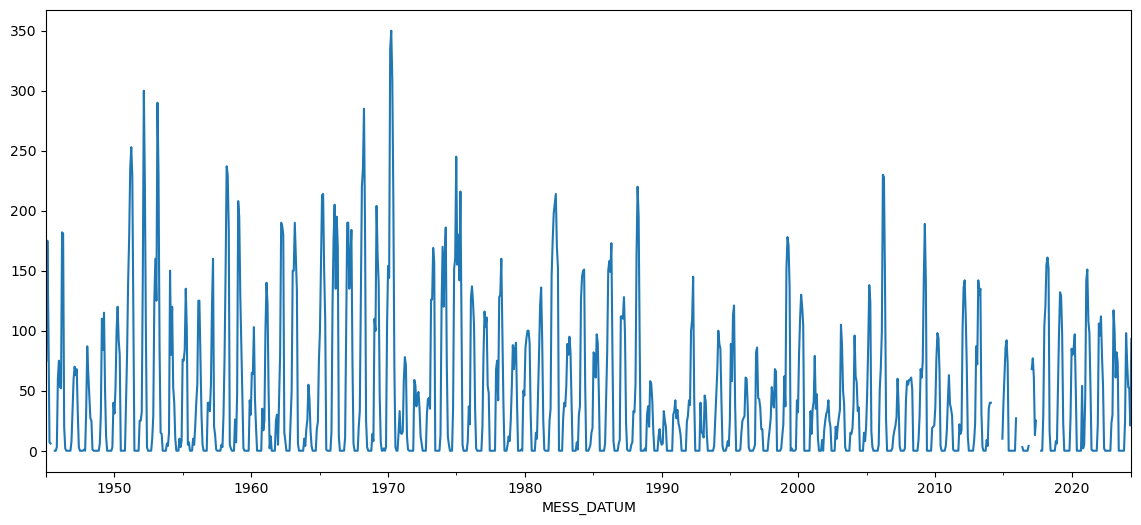

In [154]:
df.SHK_TAG.resample('4W').max().plot(figsize=(14, 6));

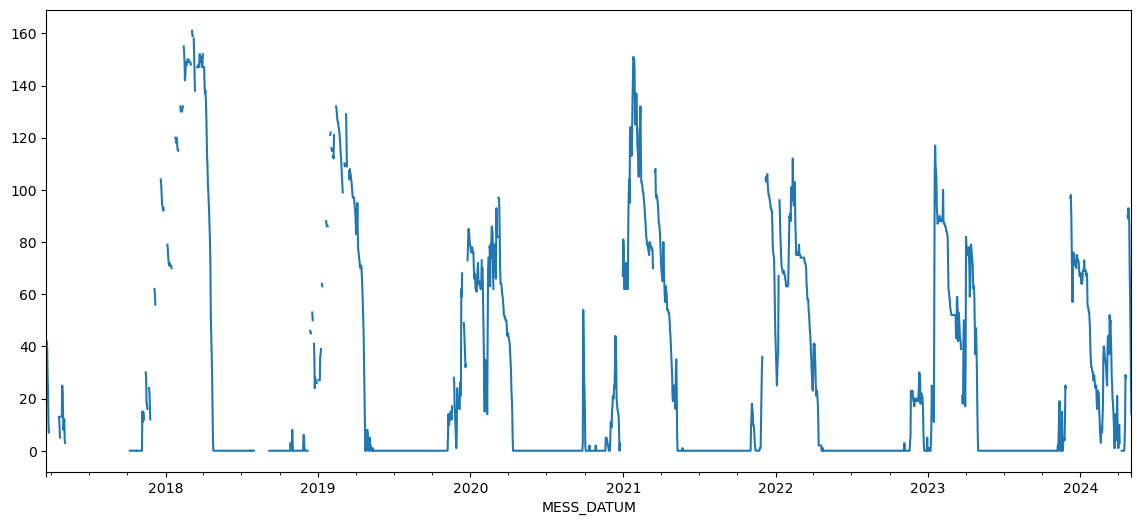

In [155]:
df.SHK_TAG[-2600:].plot(figsize=(14, 6));

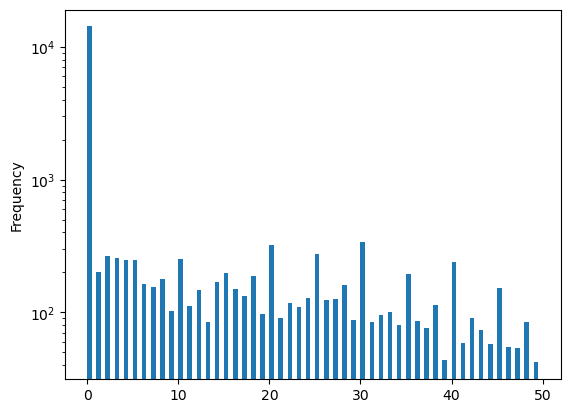

In [156]:
import numpy as np
df.SHK_TAG.plot.hist(bins=np.arange(0, 50, 0.5))
import matplotlib.pyplot as plt
plt.yscale('log')

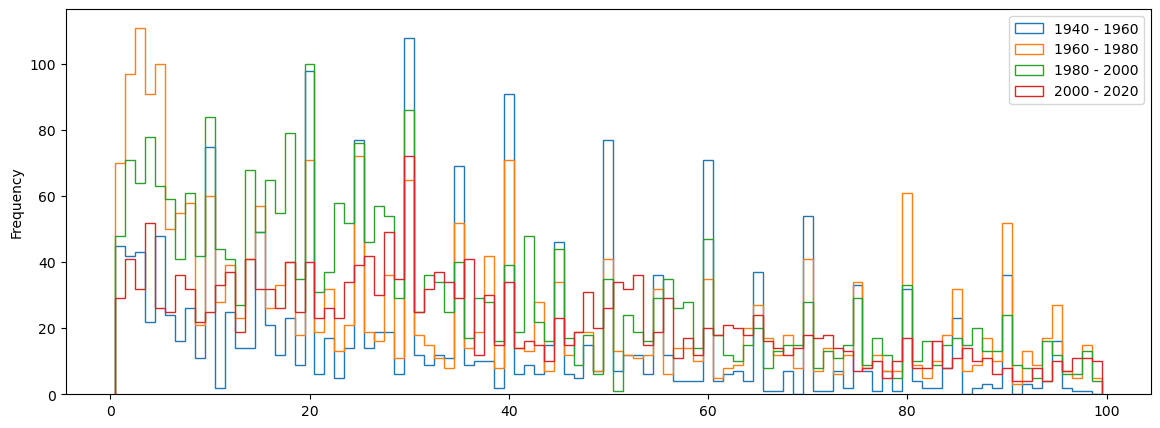

In [157]:
date_range = pd.date_range('1940', '2020', freq='20YS')
for i in range(len(date_range)-1):
    start = date_range[i]
    end = date_range[i+1]
    df.SHK_TAG[start:end].plot.hist(
        bins=np.arange(0.5, 100, 1), 
        histtype=u'step',
        #alpha=0.5,
        figsize=(14, 5),
        label=f'{start.year} - {end.year}',
    )
plt.legend();


In [158]:
df['month'] = df.index.month

df['winter_season'] = df.shift(5, freq='ME').index.year 
df = df[df.month.isin([11, 12, 1, 2, 3, 4])]

df = df[df.index.year > 1920]

In [159]:
g_list = []
for winter_season, g in df.groupby(df.winter_season):
    g['non_nan_values_per_season'] = (~g.SHK_TAG.isna()).sum()
    #g['month_day'] = range(len(g.index))
    date_range = pd.date_range(f'{winter_season-1}-11-01 00:00:00+00:00', f'{winter_season}-03-31 00:00:00+00:00')
    #g['day_of_winter_season'] = np.where(date_range.isin(g.index))
    g_list.append(g)

df_new = pd.concat(g_list)

In [160]:
df_new

,STATIONS_ID,QN_3,FX,FM,QN_4,RSK,RSKF,SDK,SHK_TAG,NM,...,PM,TMK,UPM,TXK,TNK,TGK,eor,month,winter_season,non_nan_values_per_season
MESS_DATUM,,,,,,,,,,,,,,,,,,,,,
1945-01-01,1346,NaN,NaN,NaN,5,3.2,7.0,0.000,70.0,8.0,...,851.00,-13.1,97.00,-9.8,-13.8,NaN,eor,1,1945,69
1945-01-02,1346,NaN,NaN,NaN,5,0.0,0.0,6.800,75.0,5.0,...,856.00,-10.0,67.00,-8.0,-13.8,NaN,eor,1,1945,69
1945-01-03,1346,NaN,NaN,NaN,5,0.0,0.0,1.700,70.0,5.0,...,848.40,-5.8,84.00,-3.7,-9.5,NaN,eor,1,1945,69
1945-01-04,1346,NaN,NaN,NaN,5,1.6,7.0,0.000,65.0,7.0,...,831.00,-7.4,95.00,-7.0,-8.1,NaN,eor,1,1945,69
1945-01-05,1346,NaN,NaN,NaN,5,6.4,7.0,0.000,67.0,8.0,...,834.20,-8.6,97.00,-6.8,-9.4,NaN,eor,1,1945,69
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2024-04-26,1346,1.0,20.3,10.1,1,3.5,8.0,0.133,92.0,7.3,...,839.28,-0.3,96.17,2.9,-3.0,0.1,eor,4,2024,165
2024-04-27,1346,1.0,14.7,7.3,1,0.0,6.0,9.200,87.0,5.7,...,842.15,6.0,56.17,9.2,2.5,0.1,eor,4,2024,165
2024-04-28,1346,1.0,16.7,6.9,1,0.4,6.0,0.650,70.0,7.5,...,847.54,4.6,75.71,9.2,1.9,0.1,eor,4,2024,165


In [161]:
# date_range = pd.date_range(f'{winter_season-1}-11-01', f'{winter_season}-03-31')

# import numpy as np
# np.where(date_range.isin(g.index))

(array([  0,   1,   2,   3,   4,   5,   6,   7,   8,   9,  10,  11,  12,
         13,  14,  15,  16,  17,  18,  19,  20,  21,  22,  23,  24,  25,
         26,  27,  28,  29,  30,  31,  32,  33,  34,  35,  36,  37,  38,
         39,  40,  41,  42,  43,  44,  45,  46,  47,  48,  49,  50,  51,
         52,  53,  54,  55,  56,  57,  58,  59,  60,  61,  62,  63,  64,
         65,  66,  67,  68,  69,  70,  71,  72,  73,  74,  75,  76,  77,
         78,  79,  80,  81,  82,  83,  84,  85,  86,  87,  88,  89,  90,
         91,  92,  93,  94,  95,  96,  97,  98,  99, 100, 101, 102, 103,
        104, 105, 106, 107, 108, 109, 110, 111, 112, 113, 114, 115, 116,
        117, 118, 119, 120, 121, 122, 123, 124, 125, 126, 127, 128, 129,
        130, 131, 132, 133, 134, 135, 136, 137, 138, 139, 140, 141, 142,
        143, 144, 145, 146, 147, 148, 149, 150, 151]),)

<Axes: xlabel='MESS_DATUM'>

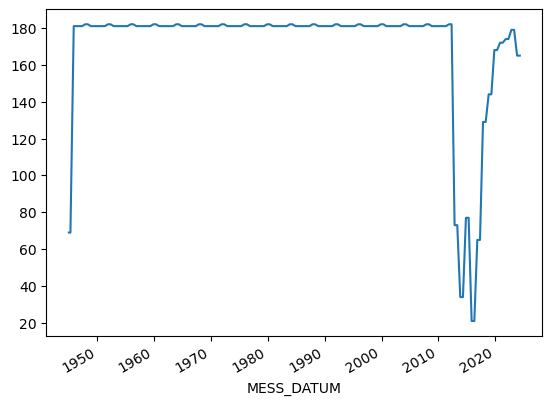

In [162]:
df_new.non_nan_values_per_season.plot()

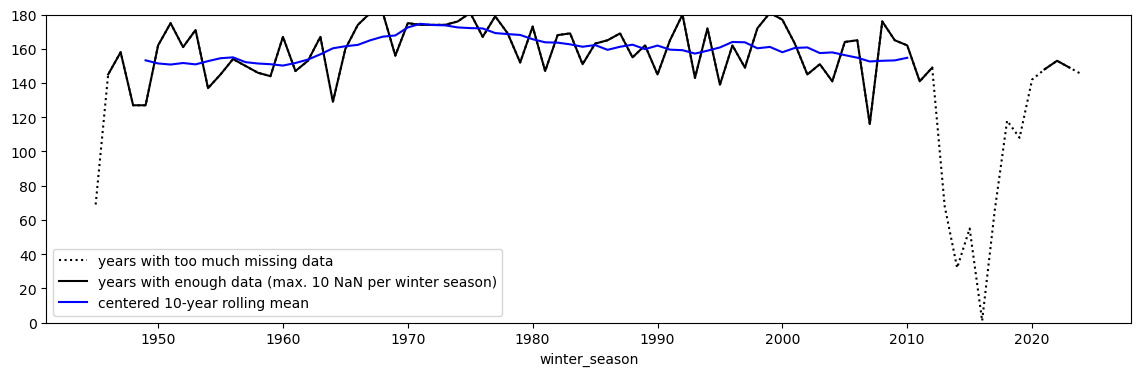

In [164]:
snow_min = 1

days_with_snow_cover = (df_new.SHK_TAG >= snow_min).groupby(df_new.winter_season).sum()
winter_season_with_enough_data = df_new.non_nan_values_per_season.groupby(df_new.winter_season).max() > 170

days_with_snow_cover.plot(figsize=(14, 8), c='k', linestyle=':', label='years with too much missing data')

days_with_snow_cover[~winter_season_with_enough_data] = pd.NA

days_with_snow_cover.plot(c='k', figsize=(14, 4), label='years with enough data (max. 10 NaN per winter season)')
#days_with_snow_cover.rolling(5, center=True, min_periods=4).mean().rolling(3, center=True, min_periods=3).mean().plot(c='b', alpha=1)
#days_with_snow_cover.rolling(5, center=True, min_periods=4).mean().plot(c='b', alpha=1, label='centered 5-year rolling mean')
#days_with_snow_cover.rolling(7, center=True, min_periods=6).mean().plot(c='b', label='centered 7-year rolling mean')
days_with_snow_cover.rolling(10, center=True, min_periods=8).mean().plot(c='b', label='centered 10-year rolling mean')
#days_with_snow_cover.rolling(10, center=True, min_periods=9).mean().plot(c='r', alpha=0.3)

plt.legend()
plt.ylim(0, 180);


In [166]:
df_shifted = df.shift(5 * 30, freq='D')
df_shifted['day_of_year'] = df_shifted.index.day_of_year
df_shifted['year'] = df_shifted.index.year

df_pivoted = df_shifted.pivot(index='year', columns='day_of_year', values='SHK_TAG')
#df_pivoted

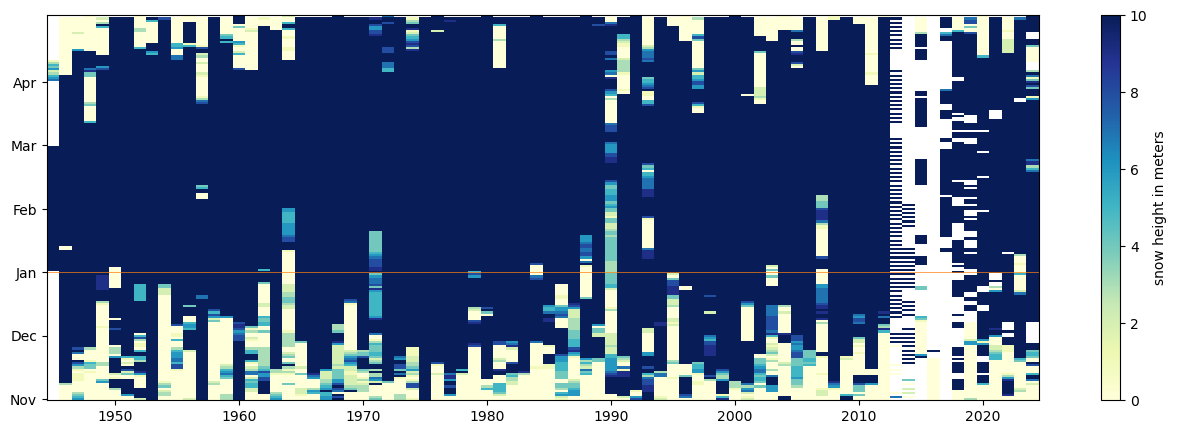

In [167]:
fig, ax = plt.subplots(figsize=(16, 5))
pc = plt.pcolormesh(df_pivoted.index, df_pivoted.columns - 5 * 30, df_pivoted.T, vmin=0, vmax=10, cmap='YlGnBu');
plt.yticks([-60, -30, 0, 30, 60, 90], labels=['Nov', 'Dec', 'Jan', 'Feb', 'Mar', 'Apr']);
plt.axhline(y=0, c='C1', linewidth=0.5)
plt.colorbar(pc, label='snow height in meters');

array([ 8.10909744e+00,  5.11973640e+01, -8.34824455e+00,  3.43984984e+00,
        1.53023053e+01,  2.56435255e+00,  4.53364180e-03,  1.05000000e+02])

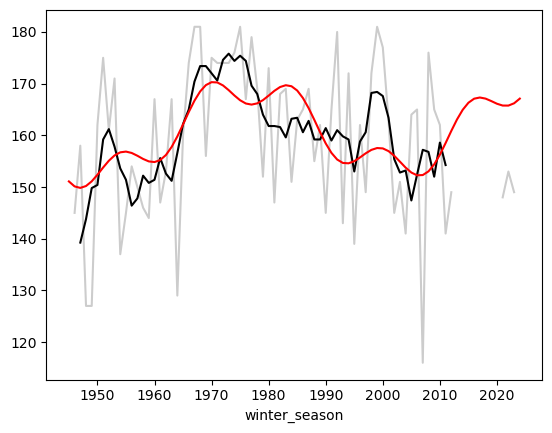

In [165]:
from scipy.optimize import curve_fit

xdata = days_with_snow_cover.rolling(5, center=True, min_periods=4).mean().dropna().index.values
ydata = days_with_snow_cover.rolling(5, center=True, min_periods=4).mean().dropna().values

def f(year, long_amplitude, long_freq, long_phase, short_amplitude, short_freq, short_phase, trend, offset):
    x = year * 2 * np.pi
    y_long = np.sin(x / long_freq + 2 * np.pi * long_phase) * long_amplitude
    y_short = np.sin(x / short_freq + 2 * np.pi * short_phase) * short_amplitude
    y = y_long + y_short + offset + x * trend
    return y

popt, pcov = curve_fit(
    f=f, 
    xdata=xdata,
    ydata=ydata,
    bounds=(
        #long_amplitude, long_freq, long_phase, short_amplitude, short_freq, short_phase, trend, offset
        (  0,  30, -10,   0, 10, -10, -1, 105),
        ( 40, 100,  10,  10, 20,  10,  1, 110),
    ),
)

days_with_snow_cover.plot(c='k', alpha=0.2)
days_with_snow_cover.rolling(5, center=True, min_periods=4).mean().plot(c='k', label='centered 5-year rolling mean')
plt.plot(days_with_snow_cover.index, f(days_with_snow_cover.index, *popt), 'r')

popt